In [2]:
"""
Reproducible Analysis: Aladynoulli vs Delphi Disease Prediction Comparison
=============================================================================

This script compares Aladynoulli (PheCode-based) predictions with Delphi (ICD-10 based) 
predictions across 1-year, 5-year, and 10-year time horizons.

Input files:
- washout_summary_table.csv: Aladynoulli 1-year predictions with washout analysis
- median_auc_results_5_year.csv: Aladynoulli 5-year predictions
- median_auc_results_10yearjointphi.csv: Aladynoulli 10-year predictions
- 41586_2025_9529_MOESM3_ESM.csv: Delphi supplementary table (ICD-10 level)
"""

import pandas as pd
import numpy as np

# =============================================================================
# 1. LOAD ALADYNOULLI RESULTS
# =============================================================================

print("Loading Aladynoulli results...")

# 1-year predictions (0 washout = all data available)
washout = pd.read_csv('/Users/sarahurbut/aladynoulli2/claudefile/output/washout_summary_table.csv')
aladynoulli_1yr = washout[['Disease', '0yr_AUC']].copy()
aladynoulli_1yr.columns = ['Disease', 'Aladynoulli_1yr']

# 5-year predictions
year_5 = pd.read_csv('/Users/sarahurbut/aladynoulli2/claudefile/output/median_auc_results_5yearjointphi.csv')
aladynoulli_5yr = year_5[['Disease', 'MedianAUC']].copy()
aladynoulli_5yr.columns = ['Disease', 'Aladynoulli_5yr']

# 10-year predictions
year_10 = pd.read_csv('/Users/sarahurbut/aladynoulli2/claudefile/output/median_auc_results_10yearjointphi.csv')
aladynoulli_10yr = year_10[['Disease', 'MedianAUC']].copy()
aladynoulli_10yr.columns = ['Disease', 'Aladynoulli_10yr']

# Merge all Aladynoulli results
aladynoulli_all = aladynoulli_1yr.merge(aladynoulli_5yr, on='Disease', how='outer')
aladynoulli_all = aladynoulli_all.merge(aladynoulli_10yr, on='Disease', how='outer')

print(f"Loaded Aladynoulli results for {len(aladynoulli_all)} diseases")

# =============================================================================
# 2. EXTRACT DELPHI RESULTS FROM SUPPLEMENTARY TABLE
# =============================================================================

print("\nExtracting Delphi results from supplementary table...")

# Load Delphi supplementary table (1,270 ICD-10 codes)
delphi_supp = pd.read_csv('/Users/sarahurbut/Downloads/41586_2025_9529_MOESM3_ESM.csv')

# Define disease category to ICD-10 code mappings
# (These are the major disease categories from the Aladynoulli analysis)
disease_icd_mapping = {
    'ASCVD': ['I21', 'I25'],  # Myocardial infarction, Coronary atherosclerosis
    'Diabetes': ['E11'],  # Type 2 diabetes
    'Atrial_Fib': ['I48'],  # Atrial fibrillation
    'CKD': ['N18'],  # Chronic renal failure
    'All_Cancers': ['C18', 'C50', 'D07'],  # Colon, Breast, Prostate
    'Stroke': ['I63'],  # Cerebral infarction
    'Heart_Failure': ['I50'],  # Heart failure
    'Pneumonia': ['J18'],  # Pneumonia
    'COPD': ['J44'],  # Chronic obstructive pulmonary disease
    'Osteoporosis': ['M81'],  # Osteoporosis
    'Anemia': ['D50'],  # Iron deficiency anemia
    'Colorectal_Cancer': ['C18'],  # Colon cancer
    'Breast_Cancer': ['C50'],  # Breast cancer
    'Prostate_Cancer': ['C61'],  # Prostate cancer
    'Lung_Cancer': ['C34'],  # Lung cancer
    'Bladder_Cancer': ['C67'],  # Bladder cancer
    'Secondary_Cancer': ['C79'],  # Secondary malignant neoplasm
    'Depression': ['F32', 'F33'],  # Depressive disorders
    'Anxiety': ['F41'],  # Anxiety disorders
    'Bipolar_Disorder': ['F31'],  # Bipolar disorder
    'Rheumatoid_Arthritis': ['M05', 'M06'],  # Rheumatoid arthritis
    'Psoriasis': ['L40'],  # Psoriasis
    'Ulcerative_Colitis': ['K51'],  # Ulcerative colitis
    'Crohns_Disease': ['K50'],  # Crohn's disease
    'Asthma': ['J45'],  # Asthma
    'Parkinsons': ['G20'],  # Parkinson's disease
    'Multiple_Sclerosis': ['G35'],  # Multiple sclerosis
    'Thyroid_Disorders': ['E03']  # Hypothyroidism
}

# Extract Delphi AUCs for each disease category
delphi_results = []

for disease_name, icd_codes in disease_icd_mapping.items():
    matching_rows = []
    
    for icd_code in icd_codes:
        # Find ICD-10 codes that start with the pattern
        matches = delphi_supp[delphi_supp['Name'].str.contains(f'^{icd_code}', regex=True, na=False)]
        if len(matches) > 0:
            matching_rows.append(matches)
    
    if len(matching_rows) > 0:
        # Combine all matching rows
        combined = pd.concat(matching_rows)
        
        # Average the AUCs (both male and female)
        female_aucs = combined['AUC Female, (no gap)'].dropna()
        male_aucs = combined['AUC Male, (no gap)'].dropna()
        
        if len(female_aucs) > 0 or len(male_aucs) > 0:
            all_aucs = pd.concat([female_aucs, male_aucs])
            avg_auc = all_aucs.mean()
            
            delphi_results.append({
                'Disease': disease_name,
                'Delphi_1yr': avg_auc,
                'N_ICD_codes': len(combined)
            })

delphi_df = pd.DataFrame(delphi_results)
print(f"Extracted Delphi results for {len(delphi_df)} diseases")

# =============================================================================
# 3. MERGE AND COMPARE
# =============================================================================

print("\nCreating comparison...")

# Merge all results
comparison = aladynoulli_all.merge(delphi_df[['Disease', 'Delphi_1yr']], on='Disease', how='outer')

# Calculate differences
comparison['Diff_1yr'] = comparison['Aladynoulli_1yr'] - comparison['Delphi_1yr']

# Sort by 1-year difference
comparison = comparison.sort_values('Diff_1yr', ascending=False)

# =============================================================================
# 4. IDENTIFY WINS
# =============================================================================

wins = comparison[comparison['Diff_1yr'] > 0].copy()

print("\n" + "=" * 100)
print("ALADYNOULLI vs DELPHI: DISEASES WHERE ALADYNOULLI WINS (1-YEAR PREDICTIONS)")
print("=" * 100)
print(f"\nTotal wins: {len(wins)} out of {len(comparison)} diseases")
print(f"Win rate: {len(wins)/len(comparison)*100:.1f}%\n")

pd.set_option('display.float_format', '{:.4f}'.format)

print(f"{'Disease':<25} {'Aladynoulli':>12} {'Delphi':>12} {'Advantage':>12} {'Percent':>10}")
print("-" * 100)

for idx, row in wins.iterrows():
    disease = row['Disease']
    ala = row['Aladynoulli_1yr']
    delp = row['Delphi_1yr']
    diff = row['Diff_1yr']
    pct = (diff / delp * 100) if delp > 0 else 0
    
    print(f"{disease:<25} {ala:>12.4f} {delp:>12.4f} {diff:>12.4f} {pct:>9.1f}%")

# =============================================================================
# 5. SUMMARY STATISTICS
# =============================================================================

print("\n" + "=" * 100)
print("SUMMARY STATISTICS")
print("=" * 100)

print(f"\n1-YEAR PREDICTIONS:")
print(f"  Aladynoulli mean (all):  {comparison['Aladynoulli_1yr'].mean():.4f}")
print(f"  Delphi mean (all):       {comparison['Delphi_1yr'].mean():.4f}")
print(f"  Overall difference:      {comparison['Diff_1yr'].mean():.4f}")

print(f"\n  Aladynoulli mean (wins): {wins['Aladynoulli_1yr'].mean():.4f}")
print(f"  Delphi mean (wins):      {wins['Delphi_1yr'].mean():.4f}")
print(f"  Average advantage:       {wins['Diff_1yr'].mean():.4f}")

print(f"\n5-YEAR PREDICTIONS:")
print(f"  Aladynoulli mean:        {comparison['Aladynoulli_5yr'].mean():.4f}")

print(f"\n10-YEAR PREDICTIONS:")
print(f"  Aladynoulli mean:        {comparison['Aladynoulli_10yr'].mean():.4f}")

# =============================================================================
# 6. TOP WINS BY CATEGORY
# =============================================================================

print("\n" + "=" * 100)
print("TOP 5 BIGGEST WINS")
print("=" * 100)

top5 = wins.head(5)
for i, (idx, row) in enumerate(top5.iterrows(), 1):
    print(f"\n{i}. {row['Disease']}")
    print(f"   Aladynoulli: {row['Aladynoulli_1yr']:.4f}")
    print(f"   Delphi:      {row['Delphi_1yr']:.4f}")
    print(f"   Advantage:   +{row['Diff_1yr']:.4f} ({row['Diff_1yr']/row['Delphi_1yr']*100:.1f}% better)")

# =============================================================================
# 7. SAVE RESULTS
# =============================================================================

print("\n" + "=" * 100)
print("SAVING RESULTS")
print("=" * 100)

# Save full comparison
comparison.to_csv('/Users/sarahurbut/aladynoulli2/claudefile/output//comparison_aladynoulli_vs_delphi_full.csv', index=False)
print("Full comparison saved to: /Users/sarahurbut/aladynoulli2/claudefile/output//comparison_aladynoulli_vs_delphi_full.csv")

# Save wins only
wins.to_csv('/Users/sarahurbut/aladynoulli2/claudefile/output//comparison_aladynoulli_vs_delphi_wins.csv', index=False)
print("Wins only saved to: /Users/sarahurbut/aladynoulli2/claudefile/output//comparison_aladynoulli_vs_delphi_wins.csv")

print("\n" + "=" * 100)
print("ANALYSIS COMPLETE")
print("=" * 100)

Loading Aladynoulli results...
Loaded Aladynoulli results for 28 diseases

Extracting Delphi results from supplementary table...
Extracted Delphi results for 28 diseases

Creating comparison...

ALADYNOULLI vs DELPHI: DISEASES WHERE ALADYNOULLI WINS (1-YEAR PREDICTIONS)

Total wins: 16 out of 28 diseases
Win rate: 57.1%

Disease                    Aladynoulli       Delphi    Advantage    Percent
----------------------------------------------------------------------------------------------------
Parkinsons                      0.8289       0.6108       0.2181      35.7%
Prostate_Cancer                 0.8646       0.6636       0.2010      30.3%
ASCVD                           0.9036       0.7370       0.1666      22.6%
Multiple_Sclerosis              0.8129       0.6545       0.1584      24.2%
Atrial_Fib                      0.8091       0.6721       0.1370      20.4%
Asthma                          0.7310       0.6144       0.1166      19.0%
Thyroid_Disorders               0.7246      

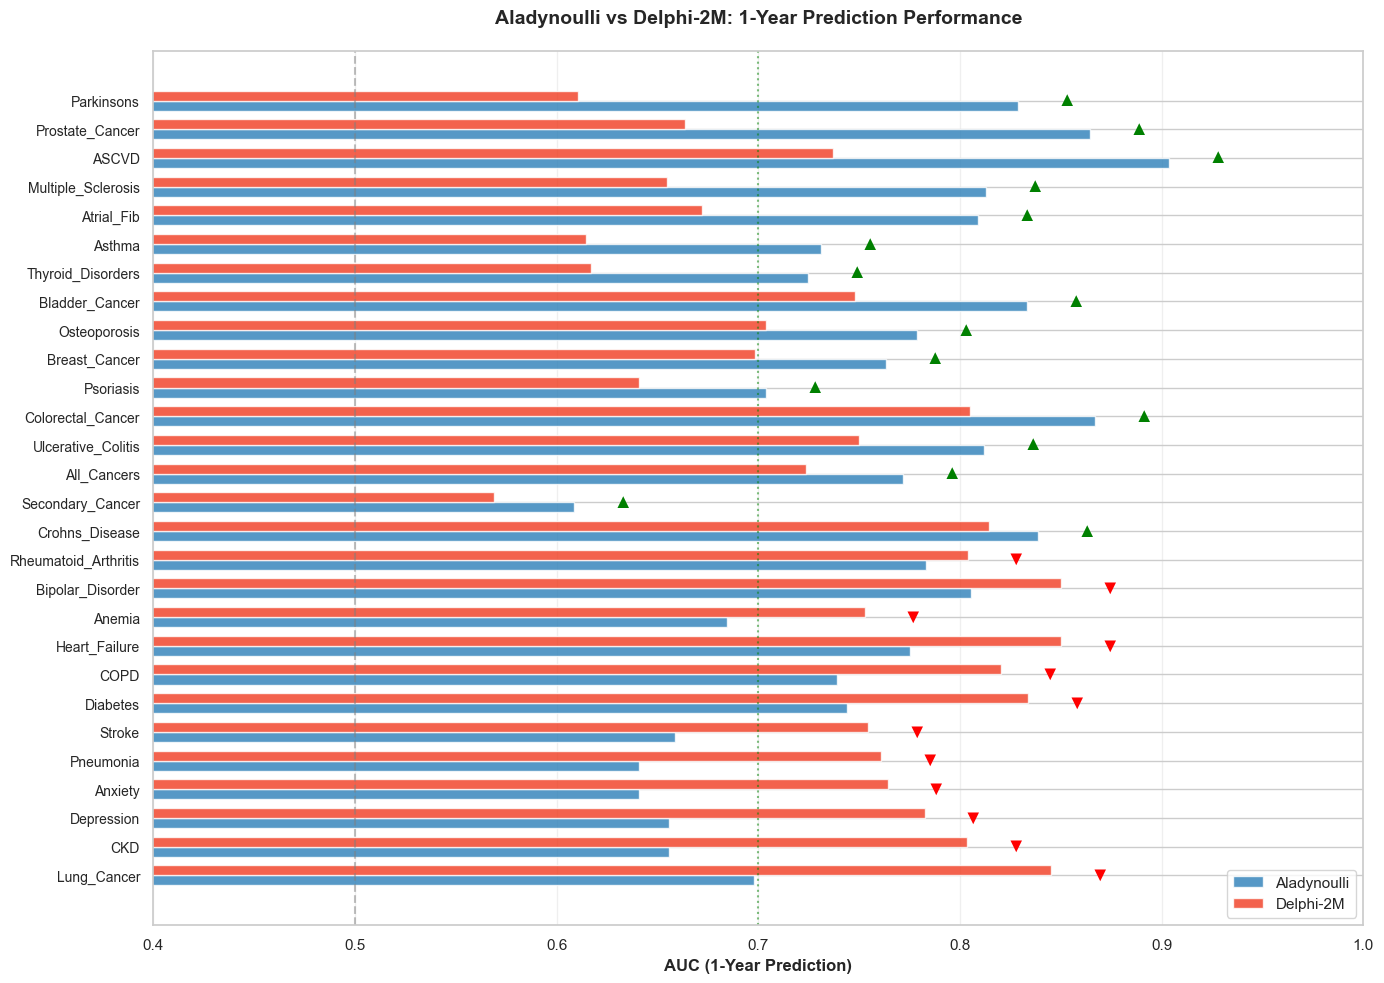

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_theme(style="whitegrid", palette="muted")

# Load data
comparison = pd.read_csv('/Users/sarahurbut/aladynoulli2/claudefile/output/comparison_aladynoulli_vs_delphi_full.csv')
comparison_valid = comparison.dropna(subset=['Aladynoulli_1yr', 'Delphi_1yr']).copy()
comparison_valid = comparison_valid.sort_values('Diff_1yr', ascending=True)

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

y_pos = np.arange(len(comparison_valid))
bar_width = 0.35

# Plot bars
bars1 = ax.barh(y_pos - bar_width/2, comparison_valid['Aladynoulli_1yr'], 
                bar_width, label='Aladynoulli', color='#2c7fb8', alpha=0.8)
bars2 = ax.barh(y_pos + bar_width/2, comparison_valid['Delphi_1yr'], 
                bar_width, label='Delphi-2M', color='#f03b20', alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(comparison_valid['Disease'], fontsize=10)
ax.set_xlabel('AUC (1-Year Prediction)', fontsize=12, fontweight='bold')
ax.set_title('Aladynoulli vs Delphi-2M: 1-Year Prediction Performance', 
             fontsize=14, fontweight='bold', pad=20)
ax.axvline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.axvline(0.7, color='green', linestyle=':', alpha=0.5)
ax.set_xlim(0.4, 1.0)
ax.legend(loc='lower right', fontsize=11)
ax.grid(axis='x', alpha=0.3)

# Add difference markers
for i, (idx, row) in enumerate(comparison_valid.iterrows()):
    diff = row['Diff_1yr']
    if abs(diff) > 0.01:
        x_pos = max(row['Aladynoulli_1yr'], row['Delphi_1yr']) + 0.02
        color = 'green' if diff > 0 else 'red'
        marker = '▲' if diff > 0 else '▼'
        ax.text(x_pos, i, marker, color=color, fontsize=12, va='center', fontweight='bold')

plt.tight_layout()
plt.show()

Loading data...
Creating main comparison figure...
Saved: figure1_main_comparison.png
Creating temporal analysis figure...
Saved: figure2_temporal_analysis.png
Creating wins focus figure...
Saved: figure3_wins_focus.png

ALL FIGURES SAVED!

1. figure1_main_comparison.png - Comprehensive 4-panel comparison
2. figure2_temporal_analysis.png - Performance across time horizons
3. figure3_wins_focus.png - Detailed view of Aladynoulli's wins

All figures saved to: /mnt/user-data/outputs/


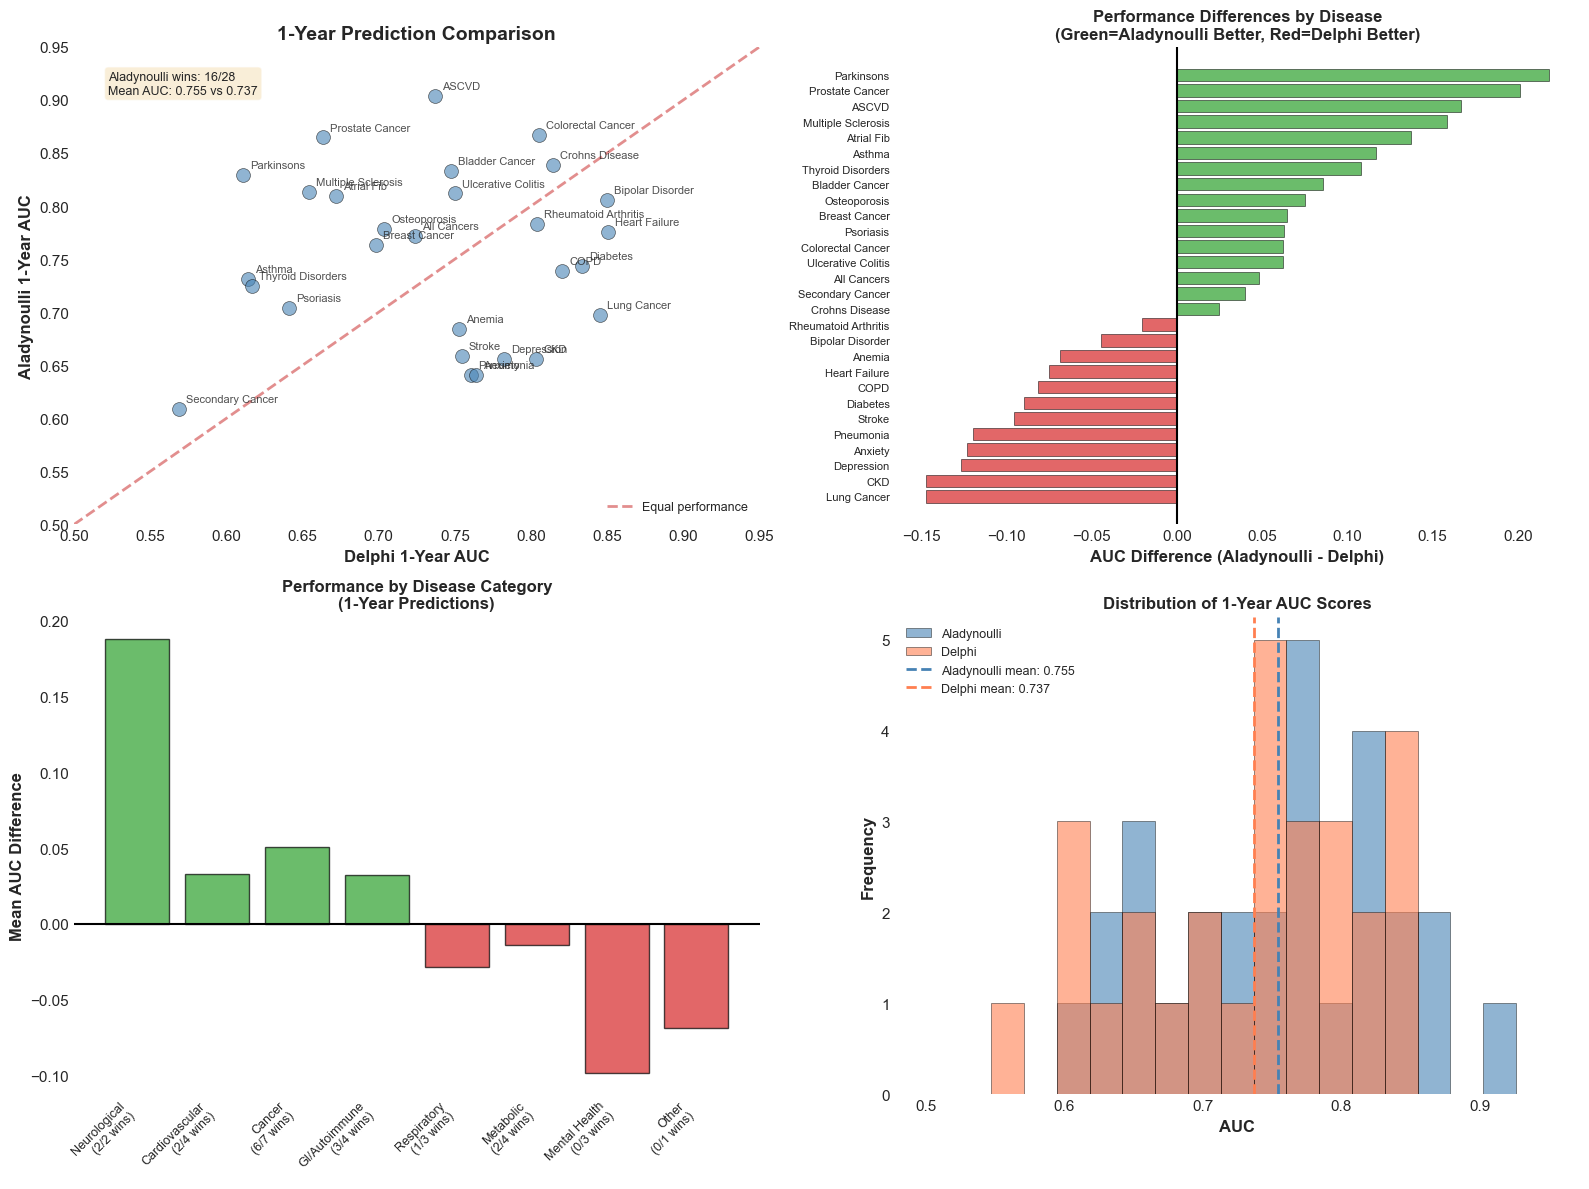

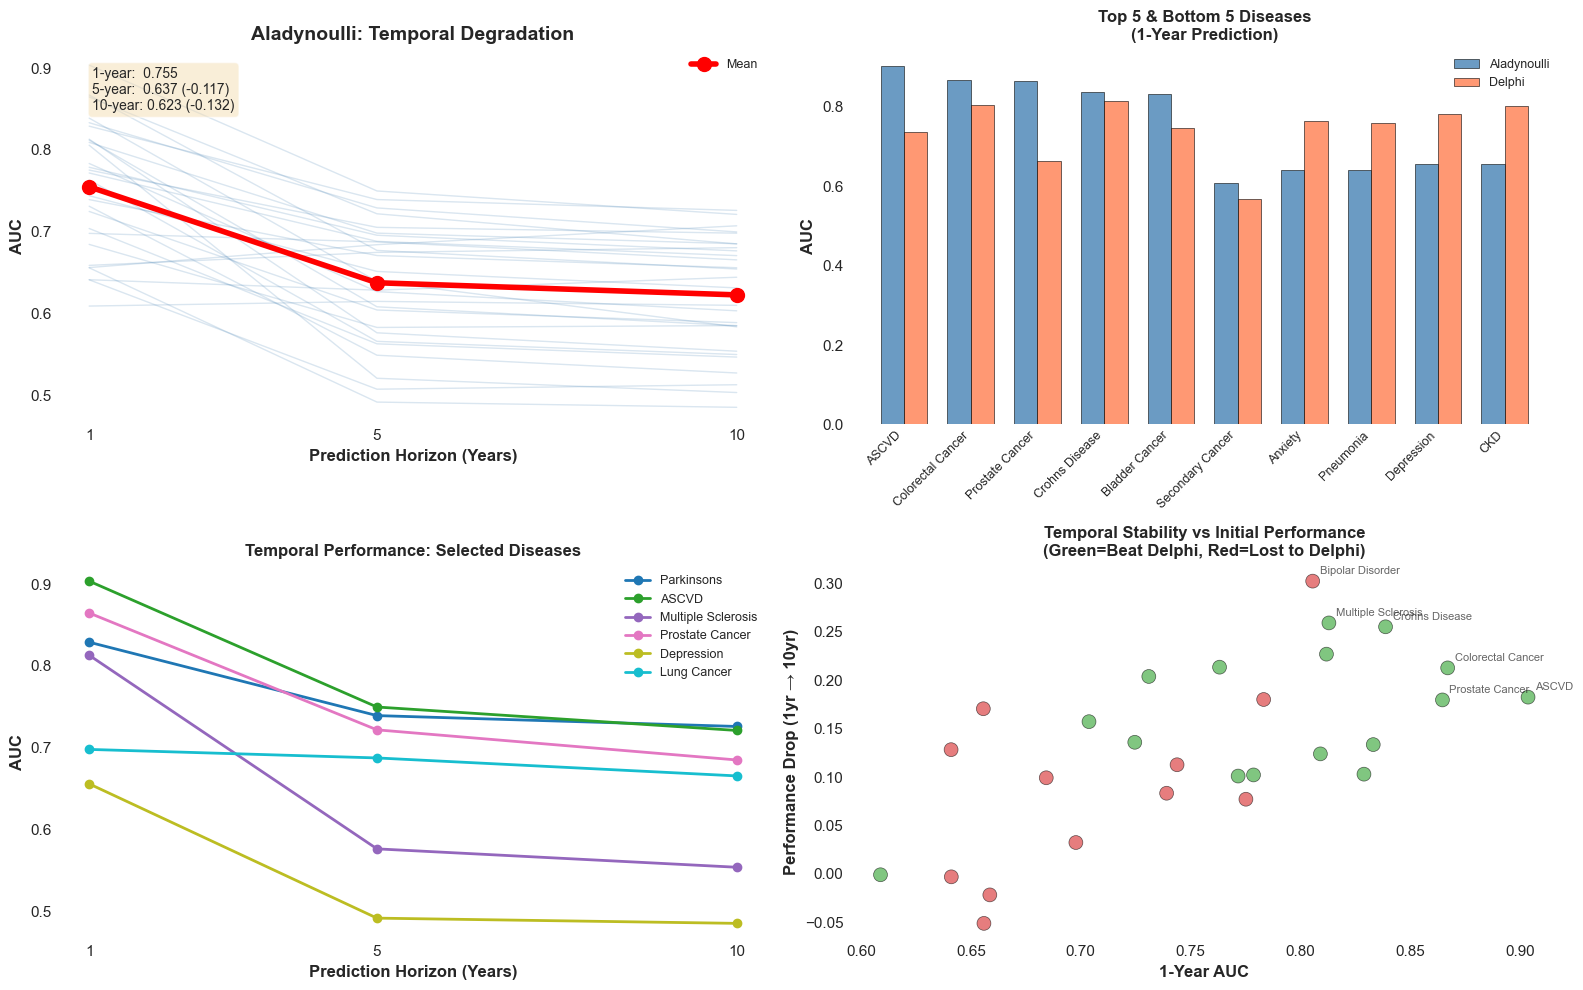

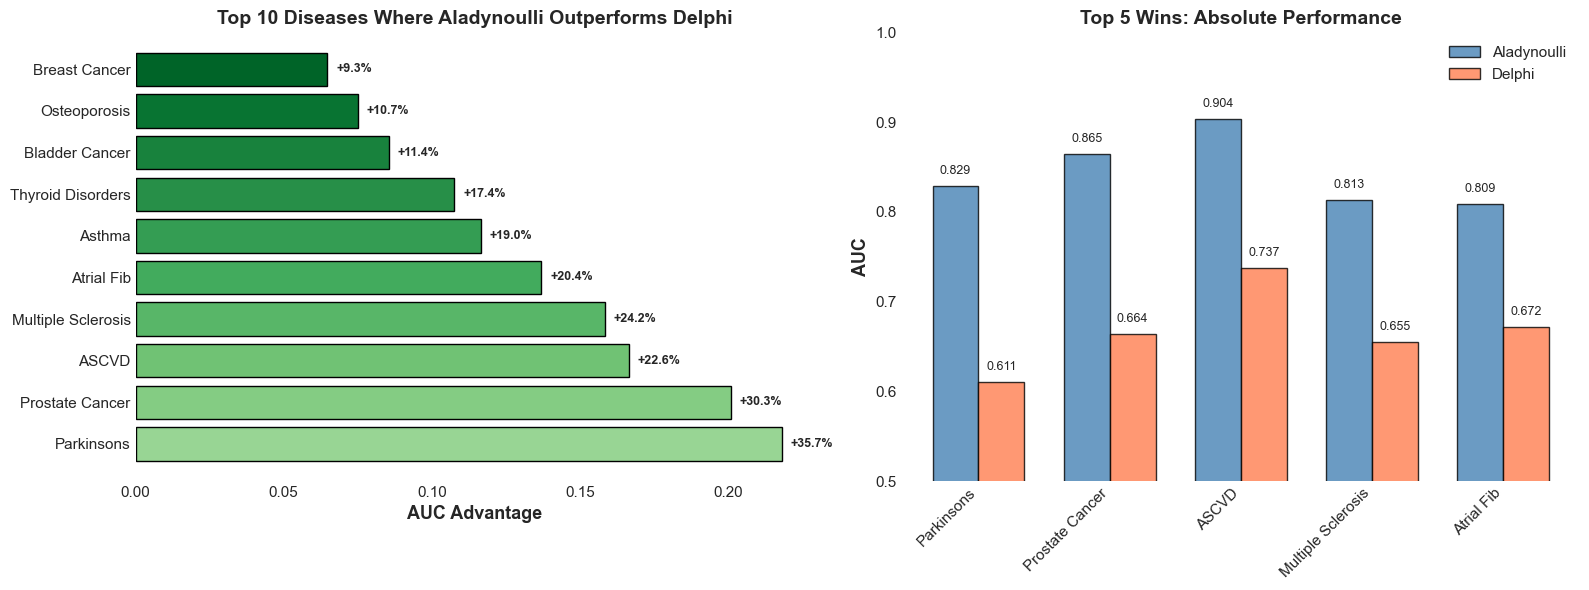

In [5]:
"""
Visualization: Aladynoulli vs Delphi Disease Prediction Comparison
===================================================================

Creates publication-quality figures comparing Aladynoulli and Delphi performance.
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set publication-quality style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9

# =============================================================================
# LOAD DATA
# =============================================================================

print("Loading data...")

# Load the comparison results
comparison = pd.read_csv('/Users/sarahurbut/aladynoulli2/claudefile/output/comparison_aladynoulli_vs_delphi_full.csv')
wins = pd.read_csv('/Users/sarahurbut/aladynoulli2/claudefile/output/comparison_aladynoulli_vs_delphi_wins.csv')

# =============================================================================
# FIGURE 1: MAIN COMPARISON (2x2 GRID)
# =============================================================================

print("Creating main comparison figure...")

fig = plt.figure(figsize=(16, 12))

# Plot 1: Scatter plot - 1-year predictions
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(comparison['Delphi_1yr'], comparison['Aladynoulli_1yr'], 
           alpha=0.6, s=100, c='steelblue', edgecolors='black', linewidth=0.5)
ax1.plot([0.5, 0.95], [0.5, 0.95], 'r--', linewidth=2, label='Equal performance', alpha=0.7)
ax1.set_xlabel('Delphi 1-Year AUC', fontsize=12, fontweight='bold')
ax1.set_ylabel('Aladynoulli 1-Year AUC', fontsize=12, fontweight='bold')
ax1.set_title('1-Year Prediction Comparison', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0.5, 0.95)
ax1.set_ylim(0.5, 0.95)

# Annotate outliers (big differences)
for idx, row in comparison.iterrows():
    ax1.annotate(row['Disease'].replace('_', ' '), 
                (row['Delphi_1yr'], row['Aladynoulli_1yr']),
                fontsize=8, alpha=0.8,
                xytext=(5, 5), textcoords='offset points')

# Add text showing overall stats
ax1.text(0.05, 0.95, f"Aladynoulli wins: {len(wins)}/28\nMean AUC: {comparison['Aladynoulli_1yr'].mean():.3f} vs {comparison['Delphi_1yr'].mean():.3f}",
         transform=ax1.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Bar chart of differences
ax2 = plt.subplot(2, 2, 2)
sorted_comp = comparison.sort_values('Diff_1yr')
colors = ['#d62728' if x < 0 else '#2ca02c' for x in sorted_comp['Diff_1yr']]
y_pos = np.arange(len(sorted_comp))
bars = ax2.barh(y_pos, sorted_comp['Diff_1yr'], color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(sorted_comp['Disease'].str.replace('_', ' '), fontsize=8)
ax2.set_xlabel('AUC Difference (Aladynoulli - Delphi)', fontsize=12, fontweight='bold')
ax2.set_title('Performance Differences by Disease\n(Green=Aladynoulli Better, Red=Delphi Better)', 
              fontsize=12, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
ax2.grid(True, alpha=0.3, axis='x')

# Plot 3: Disease category comparison
ax3 = plt.subplot(2, 2, 3)

# Define categories
categories = {
    'Neurological': ['Parkinsons', 'Multiple_Sclerosis'],
    'Cardiovascular': ['ASCVD', 'Atrial_Fib', 'Heart_Failure', 'Stroke'],
    'Cancer': ['Prostate_Cancer', 'Bladder_Cancer', 'Breast_Cancer', 'Colorectal_Cancer', 
               'Lung_Cancer', 'All_Cancers', 'Secondary_Cancer'],
    'GI/Autoimmune': ['Ulcerative_Colitis', 'Crohns_Disease', 'Rheumatoid_Arthritis', 'Psoriasis'],
    'Respiratory': ['COPD', 'Asthma', 'Pneumonia'],
    'Metabolic': ['Diabetes', 'CKD', 'Thyroid_Disorders', 'Osteoporosis'],
    'Mental Health': ['Depression', 'Anxiety', 'Bipolar_Disorder'],
    'Other': ['Anemia']
}

cat_means = []
cat_names = []
cat_wins = []

for cat_name, diseases in categories.items():
    cat_data = comparison[comparison['Disease'].isin(diseases)]
    if len(cat_data) > 0:
        mean_diff = cat_data['Diff_1yr'].mean()
        n_wins = (cat_data['Diff_1yr'] > 0).sum()
        cat_means.append(mean_diff)
        cat_names.append(f"{cat_name}\n({n_wins}/{len(cat_data)} wins)")
        cat_wins.append(n_wins / len(cat_data))

x_pos = np.arange(len(cat_names))
colors = ['#2ca02c' if x > 0 else '#d62728' for x in cat_means]
bars = ax3.bar(x_pos, cat_means, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(cat_names, fontsize=9, rotation=45, ha='right')
ax3.set_ylabel('Mean AUC Difference', fontsize=12, fontweight='bold')
ax3.set_title('Performance by Disease Category\n(1-Year Predictions)', 
              fontsize=12, fontweight='bold')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Distribution comparison
ax4 = plt.subplot(2, 2, 4)
bins = np.linspace(0.5, 0.95, 20)
ax4.hist(comparison['Aladynoulli_1yr'], bins=bins, alpha=0.6, 
         label='Aladynoulli', color='steelblue', edgecolor='black', linewidth=0.5)
ax4.hist(comparison['Delphi_1yr'], bins=bins, alpha=0.6, 
         label='Delphi', color='coral', edgecolor='black', linewidth=0.5)
ax4.axvline(comparison['Aladynoulli_1yr'].mean(), color='steelblue', 
           linestyle='--', linewidth=2, label=f"Aladynoulli mean: {comparison['Aladynoulli_1yr'].mean():.3f}")
ax4.axvline(comparison['Delphi_1yr'].mean(), color='coral', 
           linestyle='--', linewidth=2, label=f"Delphi mean: {comparison['Delphi_1yr'].mean():.3f}")
ax4.set_xlabel('AUC', fontsize=12, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax4.set_title('Distribution of 1-Year AUC Scores', fontsize=12, fontweight='bold')
ax4.legend(loc='upper left')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/sarahurbut/aladynoulli2/claudefile/output/figure1_main_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: figure1_main_comparison.png")

# =============================================================================
# FIGURE 2: TEMPORAL ANALYSIS
# =============================================================================

print("Creating temporal analysis figure...")

fig2, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Temporal degradation for all diseases
ax = axes[0, 0]
for idx, row in comparison.iterrows():
    if not pd.isna(row['Aladynoulli_5yr']) and not pd.isna(row['Aladynoulli_10yr']):
        ax.plot([1, 5, 10], 
               [row['Aladynoulli_1yr'], row['Aladynoulli_5yr'], row['Aladynoulli_10yr']], 
               alpha=0.2, color='steelblue', linewidth=1)

# Plot mean line
mean_1yr = comparison['Aladynoulli_1yr'].mean()
mean_5yr = comparison['Aladynoulli_5yr'].mean()
mean_10yr = comparison['Aladynoulli_10yr'].mean()
ax.plot([1, 5, 10], [mean_1yr, mean_5yr, mean_10yr], 
       color='red', linewidth=4, label='Mean', marker='o', markersize=10)

ax.set_xlabel('Prediction Horizon (Years)', fontsize=12, fontweight='bold')
ax.set_ylabel('AUC', fontsize=12, fontweight='bold')
ax.set_title('Aladynoulli: Temporal Degradation', fontsize=14, fontweight='bold')
ax.set_xticks([1, 5, 10])
ax.legend()
ax.grid(True, alpha=0.3)

# Add degradation stats
ax.text(0.05, 0.95, 
       f"1-year:  {mean_1yr:.3f}\n5-year:  {mean_5yr:.3f} (-{mean_1yr-mean_5yr:.3f})\n10-year: {mean_10yr:.3f} (-{mean_1yr-mean_10yr:.3f})",
       transform=ax.transAxes, fontsize=10, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Top and bottom performers
ax = axes[0, 1]
# Get top 5 and bottom 5 by 1-year performance
top5 = comparison.nlargest(5, 'Aladynoulli_1yr')
bottom5 = comparison.nsmallest(5, 'Aladynoulli_1yr')
selected = pd.concat([top5, bottom5])

x_pos = np.arange(len(selected))
width = 0.35
ax.bar(x_pos - width/2, selected['Aladynoulli_1yr'], width, 
      label='Aladynoulli', alpha=0.8, color='steelblue', edgecolor='black', linewidth=0.5)
ax.bar(x_pos + width/2, selected['Delphi_1yr'], width, 
      label='Delphi', alpha=0.8, color='coral', edgecolor='black', linewidth=0.5)

ax.set_ylabel('AUC', fontsize=12, fontweight='bold')
ax.set_title('Top 5 & Bottom 5 Diseases\n(1-Year Prediction)', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(selected['Disease'].str.replace('_', ' '), rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Performance across time horizons for selected diseases
ax = axes[1, 0]
selected_diseases = ['Parkinsons', 'ASCVD', 'Multiple_Sclerosis', 'Prostate_Cancer', 
                     'Depression', 'Lung_Cancer']
colors_map = plt.cm.tab10(np.linspace(0, 1, len(selected_diseases)))

for i, disease in enumerate(selected_diseases):
    row = comparison[comparison['Disease'] == disease].iloc[0]
    if not pd.isna(row['Aladynoulli_5yr']) and not pd.isna(row['Aladynoulli_10yr']):
        ax.plot([1, 5, 10], 
               [row['Aladynoulli_1yr'], row['Aladynoulli_5yr'], row['Aladynoulli_10yr']], 
               marker='o', linewidth=2, label=disease.replace('_', ' '), 
               color=colors_map[i])

ax.set_xlabel('Prediction Horizon (Years)', fontsize=12, fontweight='bold')
ax.set_ylabel('AUC', fontsize=12, fontweight='bold')
ax.set_title('Temporal Performance: Selected Diseases', fontsize=12, fontweight='bold')
ax.set_xticks([1, 5, 10])
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 4: Wins by prediction horizon
ax = axes[1, 1]
# This would require 5-year and 10-year Delphi data, so we'll show a different viz
# Show the relationship between 1-year performance and temporal stability

stability = []
diseases = []
for idx, row in comparison.iterrows():
    if not pd.isna(row['Aladynoulli_1yr']) and not pd.isna(row['Aladynoulli_10yr']):
        drop = row['Aladynoulli_1yr'] - row['Aladynoulli_10yr']
        stability.append(drop)
        diseases.append(row['Disease'])

df_stability = pd.DataFrame({'Disease': diseases, 'Drop': stability})
df_stability = df_stability.merge(comparison[['Disease', 'Aladynoulli_1yr', 'Diff_1yr']], on='Disease')

colors_scatter = ['#2ca02c' if x > 0 else '#d62728' for x in df_stability['Diff_1yr']]
ax.scatter(df_stability['Aladynoulli_1yr'], df_stability['Drop'], 
          s=100, alpha=0.6, c=colors_scatter, edgecolors='black', linewidth=0.5)
ax.set_xlabel('1-Year AUC', fontsize=12, fontweight='bold')
ax.set_ylabel('Performance Drop (1yr → 10yr)', fontsize=12, fontweight='bold')
ax.set_title('Temporal Stability vs Initial Performance\n(Green=Beat Delphi, Red=Lost to Delphi)', 
            fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Annotate interesting points
for idx, row in df_stability.iterrows():
    if row['Aladynoulli_1yr'] > 0.85 or row['Drop'] > 0.25:
        ax.annotate(row['Disease'].replace('_', ' '), 
                   (row['Aladynoulli_1yr'], row['Drop']),
                   fontsize=8, alpha=0.7,
                   xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.savefig('/Users/sarahurbut/aladynoulli2/claudefile/output/figure2_temporal_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: figure2_temporal_analysis.png")

# =============================================================================
# FIGURE 3: WINS FOCUS
# =============================================================================

print("Creating wins focus figure...")

fig3, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Top wins with confidence-style bars
ax = axes[0]
top10_wins = wins.nlargest(10, 'Diff_1yr')
y_pos = np.arange(len(top10_wins))
colors_gradient = plt.cm.Greens(np.linspace(0.4, 0.9, len(top10_wins)))

bars = ax.barh(y_pos, top10_wins['Diff_1yr'], color=colors_gradient, 
              edgecolor='black', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(top10_wins['Disease'].str.replace('_', ' '), fontsize=11)
ax.set_xlabel('AUC Advantage', fontsize=13, fontweight='bold')
ax.set_title('Top 10 Diseases Where Aladynoulli Outperforms Delphi', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add percentage labels
for i, (idx, row) in enumerate(top10_wins.iterrows()):
    pct = (row['Diff_1yr'] / row['Delphi_1yr'] * 100)
    ax.text(row['Diff_1yr'] + 0.003, i, f'+{pct:.1f}%', 
           va='center', fontsize=9, fontweight='bold')

# Plot 2: Side-by-side comparison for top wins
ax = axes[1]
top5_wins = wins.nlargest(5, 'Diff_1yr')
x_pos = np.arange(len(top5_wins))
width = 0.35

bars1 = ax.bar(x_pos - width/2, top5_wins['Aladynoulli_1yr'], width, 
              label='Aladynoulli', alpha=0.8, color='steelblue', edgecolor='black', linewidth=1)
bars2 = ax.bar(x_pos + width/2, top5_wins['Delphi_1yr'], width, 
              label='Delphi', alpha=0.8, color='coral', edgecolor='black', linewidth=1)

ax.set_ylabel('AUC', fontsize=13, fontweight='bold')
ax.set_title('Top 5 Wins: Absolute Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(top5_wins['Disease'].str.replace('_', ' '), rotation=45, ha='right', fontsize=11)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0.5, 1.0)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('/Users/sarahurbut/aladynoulli2/claudefile/output/figure3_wins_focus.png', dpi=300, bbox_inches='tight')
print("Saved: figure3_wins_focus.png")

print("\n" + "=" * 80)
print("ALL FIGURES SAVED!")
print("=" * 80)
print("\n1. figure1_main_comparison.png - Comprehensive 4-panel comparison")
print("2. figure2_temporal_analysis.png - Performance across time horizons")
print("3. figure3_wins_focus.png - Detailed view of Aladynoulli's wins")
print("\nAll figures saved to: /mnt/user-data/outputs/")
print("=" * 80)

In [9]:
from compare_icd10_aggregation import *
mapping_df = pd.read_csv("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/icd2phecode_mergedwithdetailedphecode_info.csv")
mapping_df.head()

,Unnamed: 0,phecode,ICD10.x,exclude_range.x,exclude_name.x,ICD10.y,phenotype,exclude_range.y,exclude_name.y
0,1,8.0000,A00,001-009.99,infectious diseases,A009,Intestinal infection,001-009.99,infectious diseases
1,2,8.0000,A000,001-009.99,infectious diseases,A009,Intestinal infection,001-009.99,infectious diseases
2,3,8.0000,A001,001-009.99,infectious diseases,A009,Intestinal infection,001-009.99,infectious diseases
3,4,8.0000,A009,001-009.99,infectious diseases,A009,Intestinal infection,001-009.99,infectious diseases
4,5,8.0000,A01,001-009.99,infectious diseases,A009,Intestinal infection,001-009.99,infectious diseases


Loading subset file (to find Phecodes): /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/icd2phecode_mergedwithdetailedphecode_subset.csv
Loading PheCode mapping from: /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/icd2phecode_mergedwithdetailedphecode_subset.csv
Loaded 347 rows
Columns: ['Unnamed: 0', 'phecode', 'uniqueICD10', 'ICD10', 'phenotype', 'exclude_range', 'exclude_name']

Loading full file (to count ICD-10 codes): /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/icd2phecode_mergedwithdetailedphecode_info.csv
Loading PheCode mapping from: /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/icd2phecode_mergedwithdetailedphecode_info.csv
Loaded 82991 rows
Columns: ['Unnamed: 0', 'phecode', 'ICD10.x', 'exclude_range.x', 'exclude_name.x', 'ICD10.y', 'phenotype', 'exclude_range.y', 'exclude_name.y']

MAPPING DISEASES TO PHECODES

ASCVD:
  Phenotypes: ['Myocardial infarction', 'Coronary atherosclerosis', 'Other acute and subacute forms of ischemic heart d

/Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision/new_notebooks/compare_icd10_aggregation.py:74: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matches = subset_df[subset_df['phenotype'].str.contains(phenotype_name, case=False, na=False)]



Diabetes:
  Phenotypes: ['Type 2 diabetes']
  Phecodes found in subset: [250.2]
  Parent Phecodes used: [250.2]
    PheCode 250.2:
      Top-level ICD-10 codes: 1 → E11
      ALL ICD-10 codes: 23 → E11, E110, E1100, E1101, E116, E1161, E11610, E11618, E1162, E11620...
  Total top-level ICD-10 codes (Delphi top-level): 1
  Total ALL ICD-10 codes (Delphi all codes): 23
  Aladynoulli uses: 1 Phecodes
  Reduction (all codes): 23 ICD-10 codes → 1 Phecodes
  Average ICD-10 codes per PheCode: 23.0

Atrial_Fib:
  Phenotypes: ['Atrial fibrillation and flutter']
  Phecodes found in subset: [427.2]
  Parent Phecodes used: [427.2]
    PheCode 427.2:
      Top-level ICD-10 codes: 1 → I48
      ALL ICD-10 codes: 1 → I48
  Total top-level ICD-10 codes (Delphi top-level): 1
  Total ALL ICD-10 codes (Delphi all codes): 1
  Aladynoulli uses: 1 Phecodes
  Reduction (all codes): 1 ICD-10 codes → 1 Phecodes
  Average ICD-10 codes per PheCode: 1.0

CKD:
  Phenotypes: ['Chronic renal failure [CKD]', 'Chroni

/Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision/new_notebooks/compare_icd10_aggregation.py:74: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matches = subset_df[subset_df['phenotype'].str.contains(phenotype_name, case=False, na=False)]



COPD:
  Phenotypes: ['Chronic airway obstruction', 'Emphysema', 'Obstructive chronic bronchitis']
  Phecodes found in subset: [496.0, 496.1, 496.21, 508.0]
  Parent Phecodes used: [496.0, 496.1, 496.21, 508.0]
    PheCode 496.0:
      Top-level ICD-10 codes: 1 → J44
      ALL ICD-10 codes: 1 → J449
    PheCode 496.1:
      Top-level ICD-10 codes: 1 → J43
      ALL ICD-10 codes: 6 → J43, J430, J431, J432, J438, J439
    PheCode 496.21:
      Top-level ICD-10 codes: 1 → J44
      ALL ICD-10 codes: 3 → J44, J440, J441
    PheCode 508.0:
      Top-level ICD-10 codes: 1 → J98
      ALL ICD-10 codes: 5 → J981, J9811, J9819, J982, J983
  Total top-level ICD-10 codes (Delphi top-level): 4
  Total ALL ICD-10 codes (Delphi all codes): 15
  Aladynoulli uses: 4 Phecodes
  Reduction (all codes): 15 ICD-10 codes → 4 Phecodes
  Average ICD-10 codes per PheCode: 3.8

Osteoporosis:
  Phenotypes: ['Osteoporosis NOS']
  Phecodes found in subset: [743.11]
  Parent Phecodes used: [743.11]
    PheCode 743.

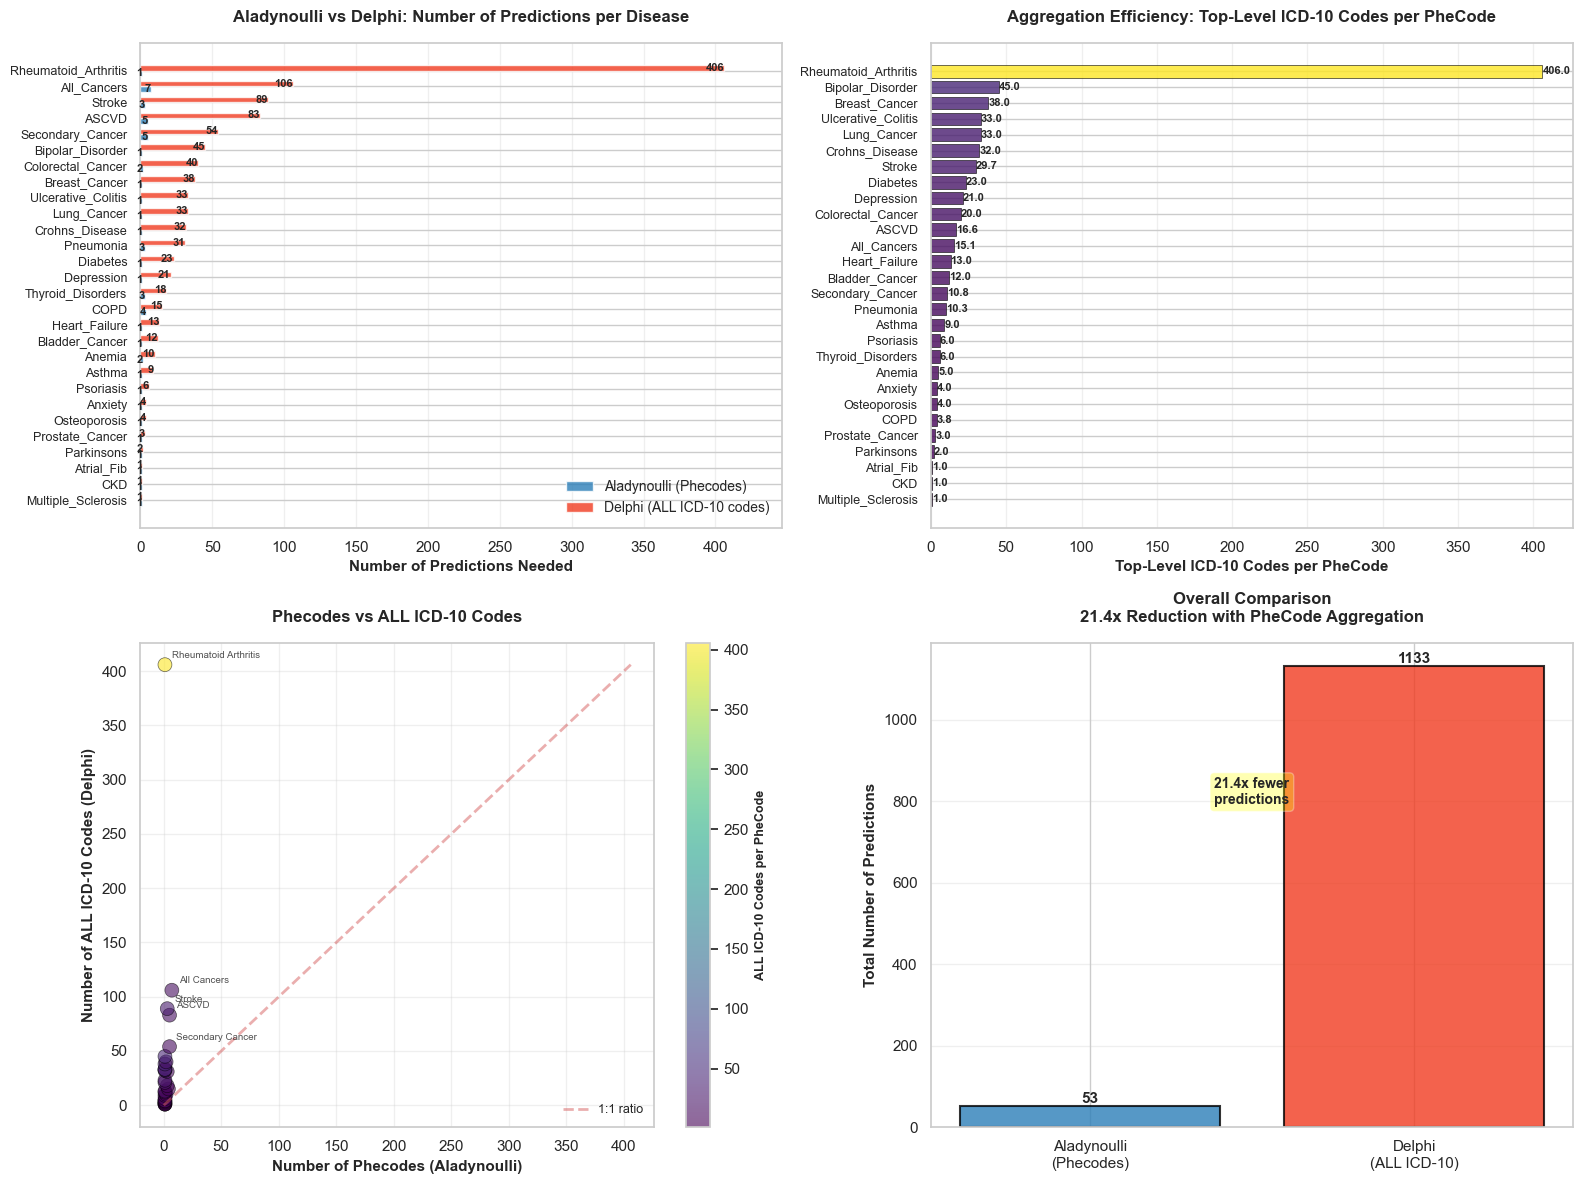

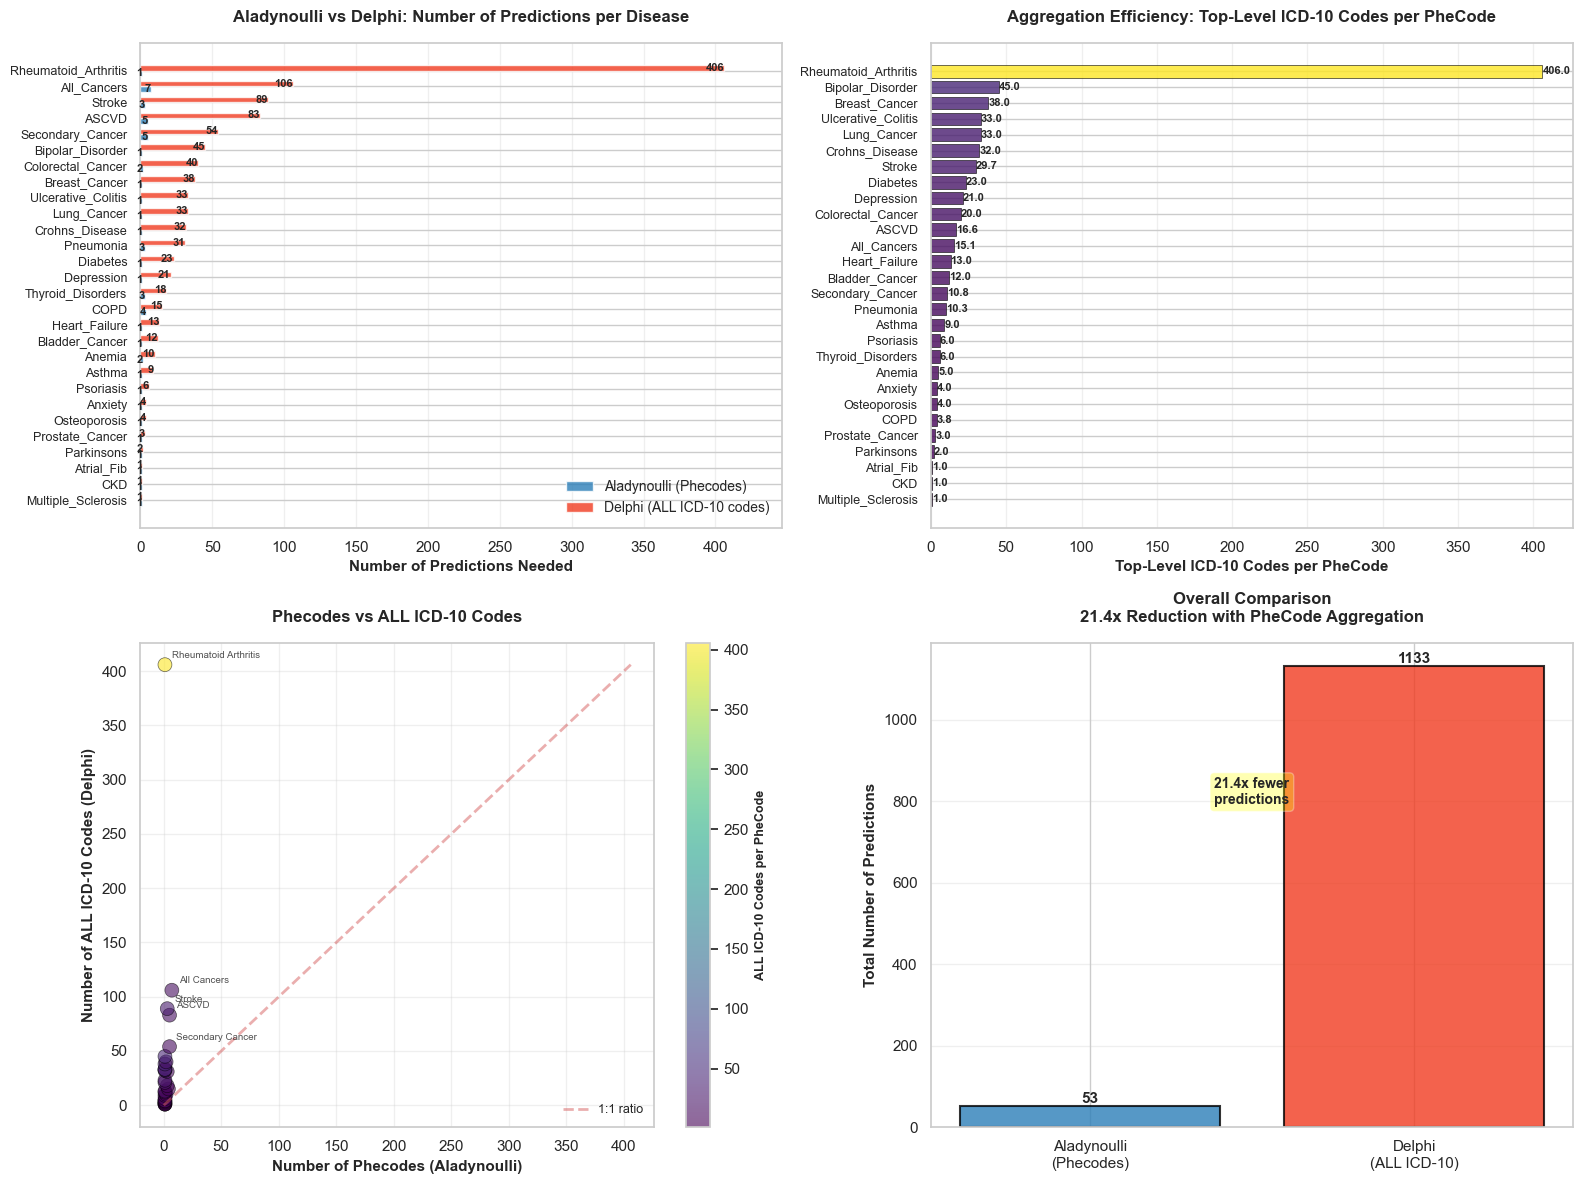

In [12]:
%load_ext autoreload
%autoreload 2

from compare_icd10_aggregation import *
# Load the PheCode mapping file
# Major diseases and their phenotype names (from fig5utils.py
major_diseases = {
    'ASCVD': ['Myocardial infarction', 'Coronary atherosclerosis', 'Other acute and subacute forms of ischemic heart disease', 
                'Unstable angina (intermediate coronary syndrome)', 'Angina pectoris', 'Other chronic ischemic heart disease, unspecified'],
    'Diabetes': ['Type 2 diabetes'],
    'Atrial_Fib': ['Atrial fibrillation and flutter'],
    'CKD': ['Chronic renal failure [CKD]', 'Chronic Kidney Disease, Stage III'],
    'All_Cancers': ['Colon cancer', 'Cancer of bronchus; lung', 'Cancer of prostate', 'Malignant neoplasm of bladder', 'Secondary malignant neoplasm','Secondary malignant neoplasm of digestive systems', 'Secondary malignant neoplasm of liver'],
    'Stroke': ['Cerebral artery occlusion, with cerebral infarction', 'Cerebral ischemia'],
    'Heart_Failure': ['Congestive heart failure (CHF) NOS', 'Heart failure NOS'],
    'Pneumonia': ['Pneumonia', 'Bacterial pneumonia', 'Pneumococcal pneumonia'],
    'COPD': ['Chronic airway obstruction', 'Emphysema', 'Obstructive chronic bronchitis'],
    'Osteoporosis': ['Osteoporosis NOS'],
    'Anemia': ['Iron deficiency anemias, unspecified or not due to blood loss', 'Other anemias'],
    'Colorectal_Cancer': ['Colon cancer', 'Malignant neoplasm of rectum, rectosigmoid junction, and anus'],
    'Breast_Cancer': ['Breast cancer [female]', 'Malignant neoplasm of female breast'],# Sex-specific
    'Prostate_Cancer': ['Cancer of prostate'], # Sex-specific
    'Lung_Cancer': ['Cancer of bronchus; lung'],
    'Bladder_Cancer': ['Malignant neoplasm of bladder'],
    'Secondary_Cancer': ['Secondary malignant neoplasm', 'Secondary malignancy of lymph nodes', 'Secondary malignancy of respiratory organs', 'Secondary malignant neoplasm of digestive systems'],
    'Depression': ['Major depressive disorder'],
    'Anxiety': ['Anxiety disorder'],
    'Bipolar_Disorder': ['Bipolar'],
    'Rheumatoid_Arthritis': ['Rheumatoid arthritis'],
    'Psoriasis': ['Psoriasis vulgaris'],
    'Ulcerative_Colitis': ['Ulcerative colitis'],
    'Crohns_Disease': ['Regional enteritis'],
    'Asthma': ['Asthma'],
    'Parkinsons': ["Parkinson's disease"],
    'Multiple_Sclerosis': ['Multiple sclerosis'],
    'Thyroid_Disorders': ['Thyrotoxicosis with or without goiter', 'Secondary hypothyroidism', 'Hypothyroidism NOS']
}


subset_path = Path("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/icd2phecode_mergedwithdetailedphecode_subset.csv")
full_path = Path("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/icd2phecode_mergedwithdetailedphecode_info.csv")



print(f"Loading subset file (to find Phecodes): {subset_path}")
subset_df = load_phecode_mapping(subset_path)

print(f"\nLoading full file (to count ICD-10 codes): {full_path}")
full_df = load_phecode_mapping(full_path)


# Map diseases to Phecodes using subset file, then count ICD-10 codes from full file
print("\n" + "="*80)
print("MAPPING DISEASES TO PHECODES")
print("="*80)
results_df = map_diseases_to_phecodes(subset_df, full_df, major_diseases)

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Total diseases analyzed: {len(results_df)}")
print(f"Total Phecodes used: {results_df['N_Phecodes'].sum()}")
print(f"Total top-level ICD-10 codes aggregated: {results_df['N_top_level_ICD10'].sum()}")
print(f"Total ALL ICD-10 codes aggregated: {results_df['N_all_ICD10'].sum()}")
print(f"Average ALL ICD-10 codes per PheCode: {results_df['ICD10_per_PheCode_avg'].mean():.1f}")
print(f"Median ALL ICD-10 codes per PheCode: {results_df['ICD10_per_PheCode_avg'].median():.1f}")

# Comparison: Aladynoulli vs Delphi
print("\n" + "="*80)
print("ALADYNOULLI vs DELPHI COMPARISON")
print("="*80)
print(f"Aladynoulli approach: Uses {results_df['N_Phecodes'].sum()} Phecodes")
print(f"Delphi approach (top-level): Uses {results_df['N_top_level_ICD10'].sum()} top-level ICD-10 codes (3-character codes)")
print(f"Delphi approach (all codes): Uses {results_df['N_all_ICD10'].sum()} ALL ICD-10 codes")
print(f"Reduction (top-level): {results_df['N_top_level_ICD10'].sum() / results_df['N_Phecodes'].sum():.1f}x fewer predictions needed")
print(f"Reduction (all codes): {results_df['N_all_ICD10'].sum() / results_df['N_Phecodes'].sum():.1f}x fewer predictions needed")

# Sort by number of ALL ICD-10 codes aggregated
results_df = results_df.sort_values('N_all_ICD10', ascending=False)

# Save results
output_dir = Path("/Users/sarahurbut/aladynoulli2/claudefile/output")
output_dir.mkdir(parents=True, exist_ok=True)

output_path = output_dir / 'icd10_aggregation_comparison.csv'
results_df.to_csv(output_path, index=False)
print(f"\n✓ Results saved to: {output_path}")

# Display top diseases by aggregation
print("\n" + "="*80)
print("TOP DISEASES BY ICD-10 AGGREGATION")
print("="*80)
display_cols = ['Disease', 'N_Phecodes', 'N_top_level_ICD10', 'N_all_ICD10', 'ICD10_per_PheCode_avg', 'Reduction_factor']
if 'Phecodes_with_counts' in results_df.columns:
    display_cols.insert(-1, 'Phecodes_with_counts')
print(results_df[display_cols].to_string(index=False))

# Create plots
print("\n" + "="*80)
print("CREATING PLOTS")
print("="*80)
create_plots(results_df, output_dir)




In [30]:
results_df

,Disease,N_Phecodes,N_top_level_ICD10,N_all_ICD10,ICD10_per_PheCode_avg,Phecodes_with_counts,Top_level_ICD10_codes,Reduction_factor
20,Rheumatoid_Arthritis,1,2,406,406.0000,"714.1(top:2, all:406)","714.1: M05,M06",406.0000
4,All_Cancers,7,24,106,15.1429,"153.2(top:5, all:23), 165.1(top:5, all:33), 18...","153.2: C18,C26,C7A,D01,Z85; 165.1: C33,C34,C7A...",15.1429
5,Stroke,3,7,89,29.6667,"433.21(top:1, all:73), 433.3(top:1, all:4), 43...","433.21: I63; 433.3: I67; 433.31: G45,G46,I67,M...",29.6667
0,ASCVD,5,14,83,16.6000,"411.2(top:6, all:34), 411.3(top:2, all:5), 411...","411.2: I21,I22,I23,I24,I25,I51; 411.3: I20,I25...",16.6000
16,Secondary_Cancer,5,12,54,10.8000,"198.0(top:5, all:26), 198.1(top:2, all:10), 19...","198.0: C78,C79,C7B,J91,R18; 198.1: C77,C7B; 19...",10.8000
19,Bipolar_Disorder,1,3,45,45.0000,"296.1(top:3, all:45)","296.1: F30,F31,F32",45.0000
11,Colorectal_Cancer,2,12,40,20.0000,"153.2(top:5, all:23), 153.3(top:7, all:17)","153.2: C18,C26,C7A,D01,Z85; 153.3: C19,C20,C21...",20.0000
12,Breast_Cancer,1,1,38,38.0000,"174.11(top:1, all:38)",174.11: C50,38.0000
22,Ulcerative_Colitis,1,1,33,33.0000,"555.2(top:1, all:33)",555.2: K51,33.0000
14,Lung_Cancer,1,5,33,33.0000,"165.1(top:5, all:33)","165.1: C33,C34,C7A,D02,Z85",33.0000



SUMMARY STATISTICS
Total diseases analyzed: 28
Total Phecodes used: 53
Total top-level ICD-10 codes aggregated: 130
Average top-level ICD-10 codes per PheCode: 28.7

ALADYNOULLI vs DELPHI COMPARISON
Aladynoulli approach: Uses 53 Phecodes
Delphi approach: Uses 130 top-level ICD-10 codes
Reduction: 2.5x fewer predictions needed
CREATING PLOTS
✓ Plot saved to: /Users/sarahurbut/aladynoulli2/claudefile/output/icd10_aggregation_comparison.png


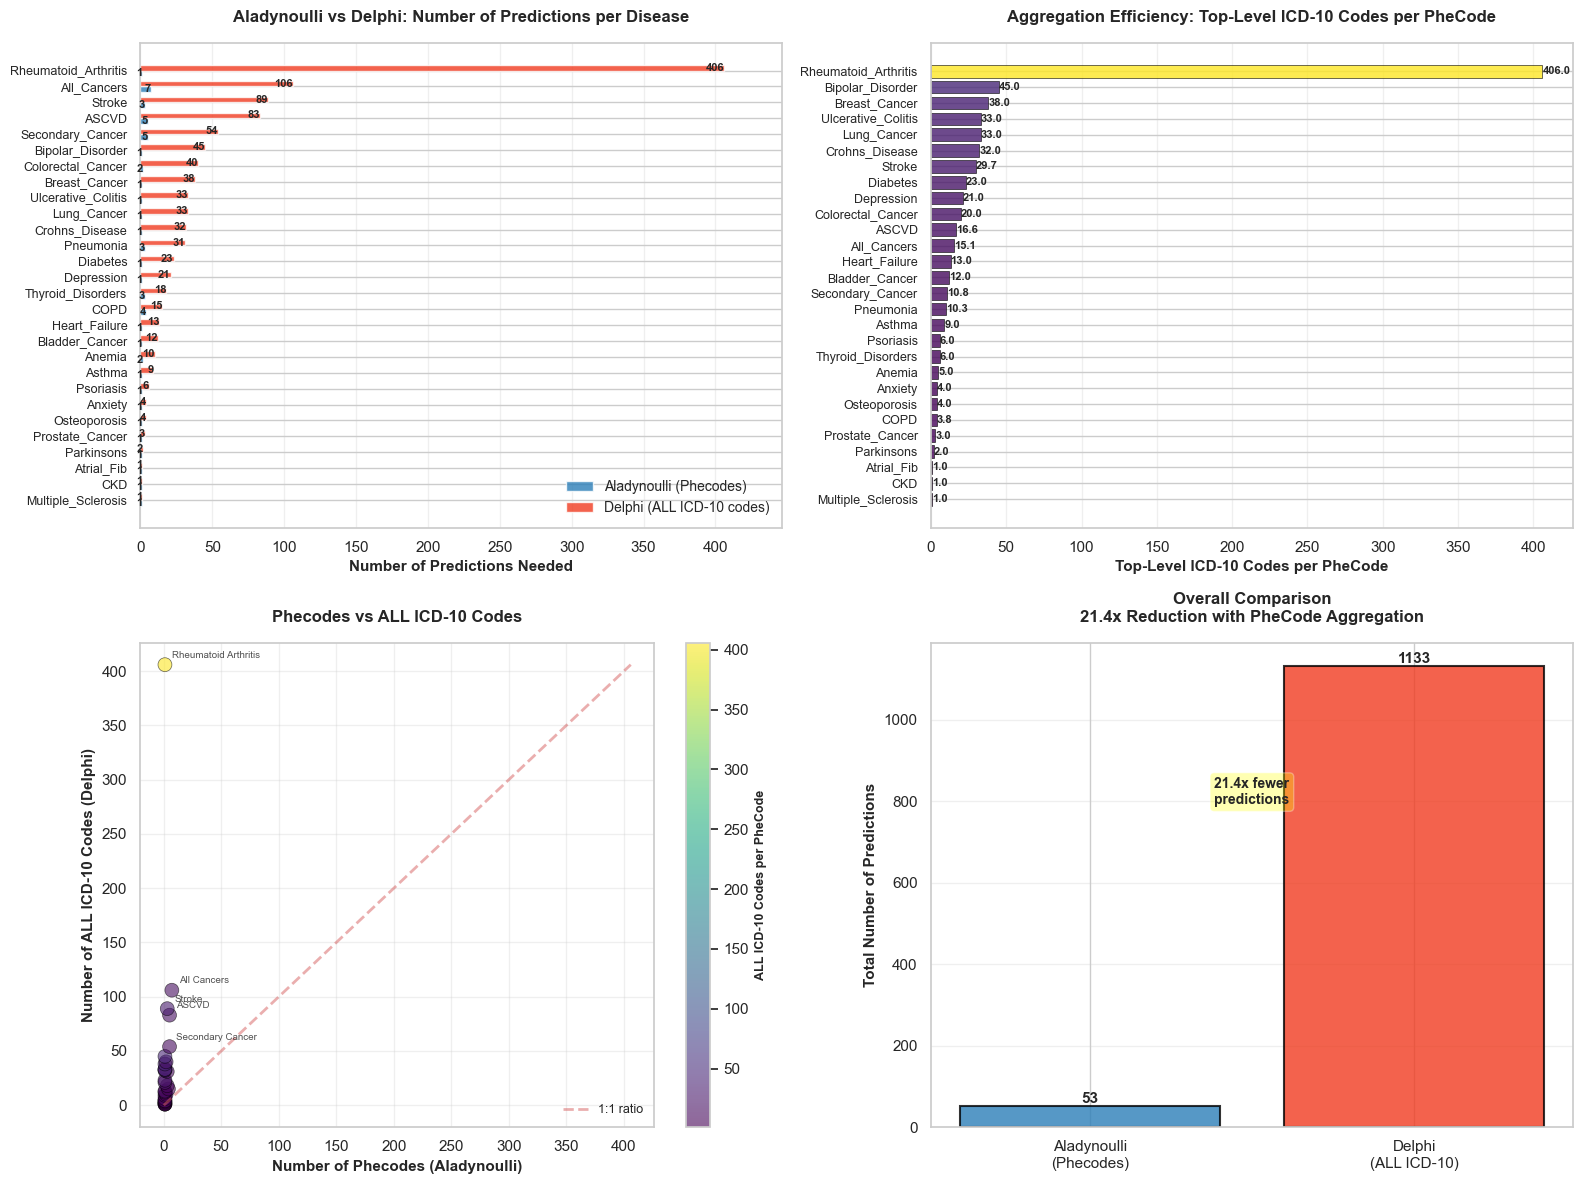

✓ Results saved to: /Users/sarahurbut/aladynoulli2/claudefile/output/icd10_aggregation_comparison.csv


In [14]:


# Summary statistics and comparison
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Total diseases analyzed: {len(results_df)}")
print(f"Total Phecodes used: {results_df['N_Phecodes'].sum()}")
print(f"Total top-level ICD-10 codes aggregated: {results_df['N_top_level_ICD10'].sum()}")
print(f"Average top-level ICD-10 codes per PheCode: {results_df['ICD10_per_PheCode_avg'].mean():.1f}")

print("\n" + "="*80)
print("ALADYNOULLI vs DELPHI COMPARISON")
print("="*80)
print(f"Aladynoulli approach: Uses {results_df['N_Phecodes'].sum()} Phecodes")
print(f"Delphi approach: Uses {results_df['N_top_level_ICD10'].sum()} top-level ICD-10 codes")
reduction = results_df['N_top_level_ICD10'].sum() / results_df['N_Phecodes'].sum()
print(f"Reduction: {reduction:.1f}x fewer predictions needed")


# Display results table
results_df_sorted = results_df.sort_values('N_top_level_ICD10', ascending=False)
display_cols = ['Disease', 'N_Phecodes', 'N_top_level_ICD10', 'ICD10_per_PheCode_avg', 'Reduction_factor']
if 'Phecodes_with_counts' in results_df_sorted.columns:
    display_cols.insert(-1, 'Phecodes_with_counts')

results_df_sorted[display_cols]

# Create and display plots
output_dir = Path("/Users/sarahurbut/aladynoulli2/claudefile/output")
output_dir.mkdir(parents=True, exist_ok=True)

print("="*80)
print("CREATING PLOTS")
print("="*80)

fig = create_plots(results_df, output_dir)

# Save results to CSV
output_path = output_dir / 'icd10_aggregation_comparison.csv'
results_df_sorted.to_csv(output_path, index=False)
print(f"✓ Results saved to: {output_path}")


CREATING PLOTS
✓ Plot saved to: /Users/sarahurbut/aladynoulli2/claudefile/output/icd10_aggregation_comparison.png


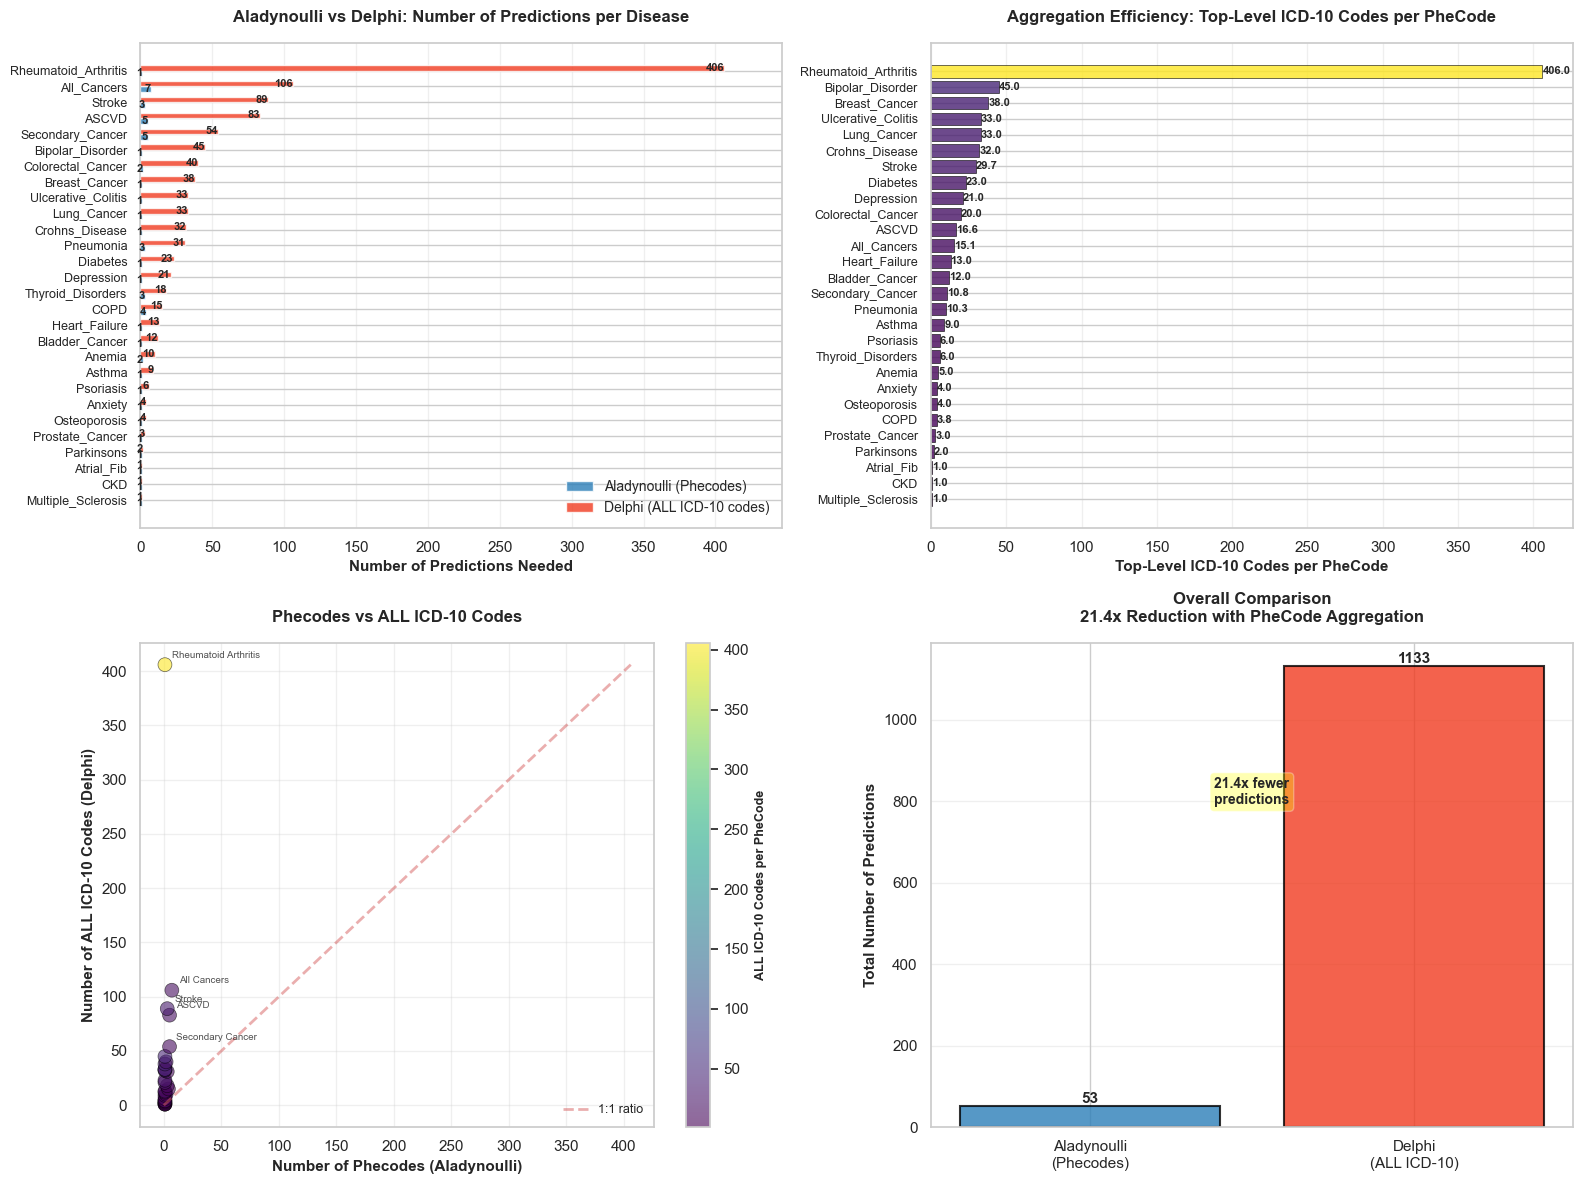

In [15]:
# Create and display plots
output_dir = Path("/Users/sarahurbut/aladynoulli2/claudefile/output")
output_dir.mkdir(parents=True, exist_ok=True)

print("="*80)
print("CREATING PLOTS")
print("="*80)

fig = create_plots(results_df, output_dir)